In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import warnings
import random
import string
import time

warnings.filterwarnings('ignore')

TIMEOUT = 5
BB_SMARTHOME_URL = 'https://www.bestbuy.com/site/home/home-security-safety/pcmcat254000050002.c?id=pcmcat254000050002'
BB_BASE_URL = 'https://www.bestbuy.com'

chop = webdriver.ChromeOptions()
chop.add_extension('/home/trevor/Software/uBlock-Origin_v1.14.16.crx')
driver = webdriver.Chrome('/home/trevor/Software/chromedriver', chrome_options=chop)

def fetch_webpage(url, retry_count=5):
    html = None
    while not html and retry_count > 0:
        try:
            driver.get(url)
            html = driver.page_source
        except requests.exceptions.RequestException:
            print('Could not connect to {}. Retry count: {}'.format(url, retry_count))
            retry_count -= 1
    return html

def get_soup(url):
    html = fetch_webpage(url)
    soup = BeautifulSoup(html, 'lxml')
    return soup

def get_links(url, selector, prepend_base_url=True):
    base_url = BB_BASE_URL if prepend_base_url else ''
    soup = get_soup(url)
    links = soup.select(selector)
    links = [(a.text, base_url + a['href']) for a in links]
    return links

devices = {}
main_category_links = get_links(BB_SMARTHOME_URL, 
                                '.navigation-link-block > .navigation-link > a')
for category_name, category_url in main_category_links:
    # Get subcategory links if subcategories exist
    subcategory_links = get_links(category_url, 
                                  '#category_facet a.value-name')
    new_devices = {}
    if subcategory_links:
        for subcategory_name, subcategory_url in subcategory_links:
            new_devices[subcategory_name] = subcategory_url
    # If there are no subcategories, just use this whole category
    else:
        new_devices[category_name] = category_url
        
    # Get the info from all devices in each category
    for new_category_name, new_category_url in new_devices.items():
        print(category_name, '>', new_category_name)
        # First, get the links for each device across each page
        # `new_category_url` will be the first page of products
        device_urls = []
        next_page_url = new_category_url
        while next_page_url:
            page_device_urls = get_links(next_page_url, '#main-results .sku-title > h4 > a')
            device_urls.extend(page_device_urls)
            next_page_button = get_links(next_page_url, '.pager-next > a', False)
            if len(next_page_button) == 0:
                next_page_url = None
            else:
                next_page_url = next_page_button[0][1]
                
        # Second, scrape text from each device page
        for device_name, device_url in device_urls:
            soup = get_soup(device_url)
            model = soup.select('#model-value')
            model = model[0].get_text() if model else 'NO-MODEL'
            sku = soup.select('#sku-value')
            sku = sku[0].get_text() if sku else 'NO-SKU'
            if model == 'NO-MODEL' and sku == 'NO-SKU':
                print('Warning: no sku or model for', device_name)
            long_description = soup.select('#long-description')
            long_description = long_description[0].get_text() if long_description else 'NO-LONG-DESC'
            included_items = soup.select('#included-items > ul > li')
            included_items = '\n'.join([li.get_text() for li in included_items]) if included_items else 'NO-INCLUDED-ITEMS'
            product_features = soup.select('#features')
            product_features = '\n'.join(product_features[0].findAll(text=True)) if product_features else 'NO-PRODUCT-FEATURES'
            devices[model+'_'+sku] = {
                'name': device_name,
                'model': model,
                'sku': sku,
                'long_description': long_description,
                'included_items': included_items,
                'product_features': product_features,
                'main_category': category_name,
                'sub_category': new_category_name
            }

In [ ]:
import pickle

with open('bestbuy-devices.pickle', 'wb') as f:
    pickle.dump(devices, f)

In [2]:
import pickle

with open('bestbuy-devices.pickle', 'rb') as f:
    devices = pickle.load(f)

# Analysis

In [8]:
import pandas as pd
import analyze_text as atxt
%matplotlib inline

# Prepare text
df = pd.DataFrame(devices).transpose().reset_index(drop=True)
df['combined_text'] = df['long_description'] + '\n' + df['product_features']
df['labels_factor'] = pd.factorize(df['sub_category'])[0]

In [ ]:
# LDA
texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['combined_text']]
atxt.run_lda(texts_tokens, 
             dictionary_save_name='bb-15_dictionary.gensim',
             corpus_save_name='bb-15_corpus.pkl', 
             model_save_name='bb-15_model.gensim', num_topics=15)

Adjusted Rand score: 0.208568865065


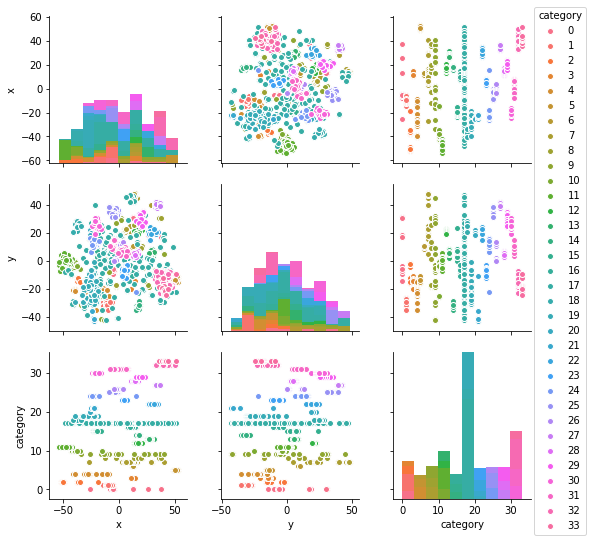

In [9]:
# TF-IDF
texts = [tuple(r) for r in df[['name', 'combined_text', 'labels_factor']].values]
atxt.run_tfidf(texts, rand_score=True, num_clusters=34)

In [12]:
# Doc2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

texts_tokens = [(atxt.prepare_text_for_lda(text), label) 
                for text, label in df[['combined_text', 'sub_category']].values]
tagged_docs = []
for i, t in enumerate(texts_tokens):
    tagged_docs.insert(0, TaggedDocument(t[0], [t[1], 'DOC_'+str(i)]))

model = Doc2Vec(tagged_docs, dm=0, alpha=0.025, size=20, min_alpha=0.025, min_count=0)
model.train(tagged_docs, total_examples=model.corpus_count, epochs=10)

601268

In [37]:
import numpy as np
import math
import random

test_part = 0.3
num_vecs = len(model.docvecs)
num_test = math.floor(test_part*num_vecs)
indices = list(range(num_vecs))
random.shuffle(indices)

test_inds = indices[:num_test]
train_inds = indices[num_test:]

# Create training set
num_train = num_vecs - num_test
train_arrays = np.zeros((num_train, 20))
train_labels = []
for i, idx in enumerate(train_inds):
    label = 'DOC_{}'.format(str(idx))
    train_arrays[i] = model.docvecs[idx]
    train_labels.insert(i, df.iloc[len(tagged_docs)-1-idx]['sub_category'])
    
# Create test set
test_arrays = np.zeros((num_test, 20))
test_labels = []
for i, idx in enumerate(test_inds):
    label = 'DOC_{}'.format(str(idx))
    test_arrays[i] = model.docvecs[idx]
    test_labels.insert(i, df.iloc[len(tagged_docs)-1-idx]['sub_category'])
    
# Classify
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_arrays, train_labels)
clf.score(test_arrays, test_labels)

0.16053511705685619

In [41]:
import random
for i in range(200):
    d = devices[random.choice(list(devices.keys()))]
    print(d['name'])
    print(d['long_description'])
    print(d['product_features'])
    print()

New! LIFX - Mini 800-Lumen, 9W Dimmable A19 LED Light Bulb, 60W Equivalent - Multicolor
Illuminate your living space with this versatile LIFX full-spectrum smart bulb. Customize the lighting in your room with the LIFX mobile app to adjust the bulb's color, warmth and intensity. Energy-efficient and robust, this LIFX full-spectrum smart bulb uses only 9W and lasts up to 22.8 years before requiring replacement.
Compatible with most 100 - 240V fixtures
For wide-ranging use. Not designed for use with other fixture types.
9W of power
Deliver the equivalent of a 60W standard halogen floodlight bulb for efficiency.
800 lumens light output
Efficiently illuminates a dark area.
White light that fits your needs
Choose from 16 million colors and a full range of warm to cool whites.
LED bulb technology
Designed to provide longer, more energy-efficient illumination.
Unified control
Works with Amazon Alexa, Apple HomeKit, the Google Assistant, Nest, Samsung SmartThings, IFTTT, Flic, Scout and more fo